# Model Iteration 2 -- Earthquake Dataset

Keenan and James

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

import re

%matplotlib inline

quakes = pd.read_csv("./data/data.csv")

print quakes.head()

                       time  latitude  longitude  depth  mag magType  nst  \
0  1901-08-09T18:33:00.000Z        40        144      0  7.5      mw  NaN   
1  1901-08-09T13:01:00.000Z       -22        170      0  7.9      mw  NaN   
2  1902-04-19T02:23:00.000Z        14        -91      0  7.5      mw  NaN   
3  1902-09-23T20:18:00.000Z        16        -93      0  7.8      mw  NaN   
4  1902-09-22T01:46:00.000Z        18        146      0  7.5      mw  NaN   

   gap  dmin  rms    ...                      updated  \
0  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
1  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
2  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
3  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   
4  NaN   NaN  NaN    ...     2015-05-13T18:52:41.000Z   

                                       place        type horizontalError  \
0        off the east coast of Honshu, Japan  earthquake             NaN   
1           southeast of the Loyalty Islan

We wrote some helper functions that will help us test the progress we have made in the models quickly.

In [17]:
from sklearn.cross_validation import train_test_split

def cross_validate(model, X, y, cv=3):
    return cross_validation.cross_val_score(model, X, y, cv=cv).mean()

def train_test_splitter(model, X, y, train_size=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

### Features

In [18]:
def magclassify(mag):
    if mag < 4:
        return 0
    elif mag < 5:
        return 1
    elif mag < 6:
        return 2
    elif mag < 7:
        return 3
    elif mag < 8:
        return 4
    elif mag >= 8:
        return 5
# "minor" "light" "moderate" "strong" "major" "great"   

def classifyMagType(magType):
    duration = ["Md", "md"]
    local = ["ml"]
    shortPS = ["mb_lg", "lg", "mblg"]
    shortPeriodWave = ["mb"]
    twenty = ["ms", "ms_20"]
    moment = ["mi", "mwp"]
    energy = ["me"]
    
    mw = ["mw", "mwb", "mwc","mwr","mww"]
    magType = str(magType).lower()
    if magType in duration:
        return 0
    elif magType in local:
        return 1
    elif magType in shortPS:
        return 2
    elif magType in shortPeriodWave:
        return 3
    elif magType in twenty:
        return 4
    elif magType in moment:
        return 5
    elif magType in energy:
        return 6
    elif magType in mw:
        return 7
    else:
        return 8    
    
def parse_date(Dates):
    return int(Dates[0:4]), int(Dates[5:7]), int(Dates[8:10]), int(Dates[11:13])

In [19]:
def add_features():
    quakes["magClassified"] = quakes["mag"].apply(magclassify)
    quakes["depth"] = quakes["depth"].fillna(quakes["depth"].median())
    quakes["magTypeClassified"] =  quakes["magType"].apply(classifyMagType)
    quakes["year"] = quakes.time.apply(lambda x: parse_date(x)[0])
    quakes["month"] = quakes.time.apply(lambda x: parse_date(x)[1])
    quakes["hour"] = quakes.time.apply(lambda x: parse_date(x)[3])

In [20]:
add_features()

In [21]:
logistic = LogisticRegression()
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=4, min_samples_leaf=8)
predictors = ["latitude", "longitude", "depth"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.78438879249106219

In [22]:
predictors = ["latitude", "longitude", "depth", "magTypeClassified", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.85702099661119591

In [26]:
predictors = ["latitude", "longitude", "year", "month","hour"]
X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
alg.fit(X_train, y_train)
alg.score(X_test, y_test)

0.80518743231125756

In [27]:
predicted = np.array(alg.predict_proba(X_test))

print predicted.shape

(343484, 6)


In [235]:
lat = 42.2926850
lon = -71.2644100
year = 2016
month = 3
hour = 10

quakeCenter = [lat, lon]
time = [year, month, hour]


The fifth decimal place is worth up to 1.1 m: it distinguish trees from each other. Accuracy to this level with commercial GPS units can only be achieved with differential correction.

[[ 0.95162338  0.04837662  0.          0.          0.          0.        ]]


/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


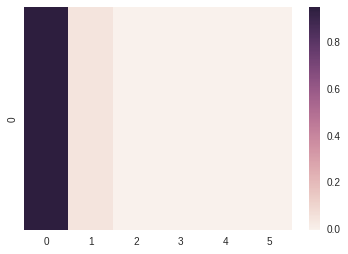

In [238]:
a = alg.predict_proba(quakeCenter + time)
print a
sns.heatmap(a)

In [224]:
lat = 42.00000
lon = -71.00000

center = [lon, lat]

def point_grid(center, size):
    points = []
    for i in range(0,size/2):
        center[0] -= 1
        center[1] -= 1
    Matrix = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(1,size + 1):
        for j in range(1, size + 1):
            Matrix[i-1][j-1] = ((center[0] + 1*j), (center[1] + 1*i))

    return Matrix
    
print point_grid(center, 5)


[[(-72.0, 41.0), (-71.0, 41.0), (-70.0, 41.0), (-69.0, 41.0), (-68.0, 41.0)], [(-72.0, 42.0), (-71.0, 42.0), (-70.0, 42.0), (-69.0, 42.0), (-68.0, 42.0)], [(-72.0, 43.0), (-71.0, 43.0), (-70.0, 43.0), (-69.0, 43.0), (-68.0, 43.0)], [(-72.0, 44.0), (-71.0, 44.0), (-70.0, 44.0), (-69.0, 44.0), (-68.0, 44.0)], [(-72.0, 45.0), (-71.0, 45.0), (-70.0, 45.0), (-69.0, 45.0), (-68.0, 45.0)]]


[[(-123.119904, 36.352693), (-122.119904, 36.352693), (-121.119904, 36.352693), (-120.119904, 36.352693), (-119.119904, 36.352693)], [(-123.119904, 37.352693), (-122.119904, 37.352693), (-121.119904, 37.352693), (-120.119904, 37.352693), (-119.119904, 37.352693)], [(-123.119904, 38.352693), (-122.119904, 38.352693), (-121.119904, 38.352693), (-120.119904, 38.352693), (-119.119904, 38.352693)], [(-123.119904, 39.352693), (-122.119904, 39.352693), (-121.119904, 39.352693), (-120.119904, 39.352693), (-119.119904, 39.352693)], [(-123.119904, 40.352693), (-122.119904, 40.352693), (-121.119904, 40.352693), (-120.119904, 40.352693), (-119.119904, 40.352693)]]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]
None


/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/keenan/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

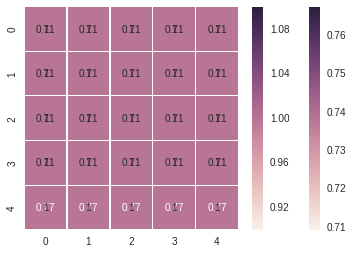

In [262]:
lat =37.352693
lon = -122.119904
center = [lon, lat]

# print alg.predict_proba([-122,37,2016,3,10])
# print alg.predict_proba([-129,49,2016,3,10])

def heatmap(quakesLoc, time):
    size = len(quakesLoc[0])
    print quakesLoc
    Scores = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(0,size):
        for j in range(0,size):
            
            point = list(quakesLoc[i][j]) + time
#             sns.heatmap(alg.predict_proba(point), annot=True)
#             sns.plt.show()
            score = max(alg.predict_proba(point)[0])
            Scores[i][j] = score
            
    sns.heatmap(Scores, annot=True, linewidths = 0.2)

def predmap(quakesLoc, time):
    size = len(quakesLoc[0])
    print quakesLoc
    Scores = [[0 for x in range(size)] for x in range(size)] 
    Predictions = [[0 for x in range(size)] for x in range(size)] 
    
    for i in range(0,size):
        for j in range(0,size):
            
            point = list(quakesLoc[i][j]) + time
#             sns.heatmap(alg.predict_proba(point), annot=True)
#             sns.plt.show()
            predict = alg.predict(point)
            print predict
            Predictions[i][j] = predict.item(0)
            
    sns.heatmap(Predictions, annot=True, linewidths = 0.2) 

heatmap(point_grid(center,5), time)
heatmap(point_grid(center,5), time)

In [ ]:
# predictors = ["latitude", "longitude", "year", "month", "hour"]
# X_train, X_test, y_train, y_test = train_test_split(quakes[predictors], quakes.magClassified, train_size=.5)
# logistic.fit(X_train, y_train)
# logistic.score(X_test, y_test)

In [ ]:
# for i in range(100):
#     a=  logistic.predict_proba([42.2926850+i,-71.2644100-i, 2016, 3, 12])
#     print weighted(a[0])
    
# def weighted(a):
#     s= 0
#     for i in range(6):
#         s += i *a[i]
#     return s/6